In [1]:
import numpy as np
import pathlib
import PIL
from glob import glob
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  GlobalMaxPooling2D, Dropout, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
train_path =  "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

train_dir = pathlib.Path((train_path))
test_dir = pathlib.Path((test_path))

# Basic data information

In [15]:
class_names = os.listdir(train_path)
print('class names: ' + str(class_names))
print('\n\n')
train_count = len(list(train_dir.glob('*/*.jp*g')))
print('train data: ' + str(train_count))
test_count = len(list(test_dir.glob('*/*.jp*g')))
print('test data: ' + str(test_count))

class names: ['Quince', 'Grapefruit White', 'Granadilla', 'Orange', 'Apple Red 3', 'Grape White 2', 'Corn Husk', 'Tamarillo', 'Banana Red', 'Nectarine Flat', 'Pepper Yellow', 'Nut Forest', 'Pear Monster', 'Fig', 'Tomato Heart', 'Onion Red Peeled', 'Lemon Meyer', 'Onion Red', 'Passion Fruit', 'Cucumber Ripe', 'Cactus fruit', 'Tomato not Ripened', 'Mango Red', 'Apple Pink Lady', 'Pomegranate', 'Plum', 'Pineapple', 'Tomato 1', 'Cherry 2', 'Apple Red 2', 'Avocado ripe', 'Dates', 'Maracuja', 'Papaya', 'Nut Pecan', 'Pear Stone', 'Cherry Wax Yellow', 'Eggplant', 'Apple Golden 2', 'Guava', 'Beetroot', 'Tomato Maroon', 'Potato Red', 'Apple Red Delicious', 'Cherry Wax Red', 'Kiwi', 'Cherry Wax Black', 'Limes', 'Cantaloupe 2', 'Apple Braeburn', 'Pear', 'Carambula', 'Tomato 3', 'Onion White', 'Cherry 1', 'Strawberry', 'Lychee', 'Redcurrant', 'Rambutan', 'Potato Red Washed', 'Tomato 4', 'Hazelnut', 'Tomato Yellow', 'Plum 3', 'Grape White', 'Pineapple Mini', 'Mulberry', 'Grape Blue', 'Pear Abate', '

# Plot data sample

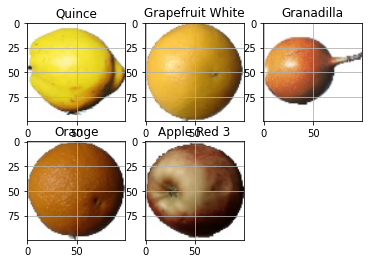

In [13]:
for i in range(5):
    plt.subplot(2, 3, i+1)
    image = cv2.imread(str(list(train_dir.glob(class_names[i]+'/*.jp*g'))[0]))  # default is BGR
    image = image[:, :, [2, 1, 0]] # reordering the colors channels to be RGB
    plt.imshow(image)
    plt.title(class_names[i])
    plt.grid()

# data augmentation

In [16]:
train_datagen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.1,  height_shift_range = 0.1,
                                  horizontal_flip = True, zoom_range = 0.2, shear_range = 0.1,
                                  preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)



In [17]:
image_shape = (200, 200)
batch_size = 32

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = 'categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [18]:
init_model = VGG16(input_shape = image_shape + (3,), weights = 'imagenet', include_top = False)
for layer in init_model.layers:
    layer.trainable = False

x = Flatten()(init_model.output)
x = Dense(131, activation = 'softmax')(x)

model = Model(inputs = init_model.input, outputs = x)

model.summary()

2022-11-30 08:56:11.694016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 08:56:11.694936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 08:56:11.703330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 08:56:11.704159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 08:56:11.704913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint',save_best_only = True,
                                                               monitor = 'val_accuracy', mode = 'max')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = ['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_data,batch_size = 512, epochs = 5, validation_data = (test_data),
                 callbacks = [model_checkpoint_callback])

2022-11-30 08:56:48.093582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-30 08:56:49.841248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2116/2116 [==============================] - 878s 412ms/step - loss: 2.2141 - accuracy: 0.9265 - auc: 0.9683 - val_loss: 3.8703 - val_accuracy: 0.9505 - val_auc: 0.9771


2022-11-30 09:11:27.439555: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/5
2116/2116 [==============================] - 883s 417ms/step - loss: 0.9216 - accuracy: 0.9798 - auc: 0.9910 - val_loss: 4.0305 - val_accuracy: 0.9627 - val_auc: 0.9820
Epoch 3/5
2116/2116 [==============================] - 850s 402ms/step - loss: 0.7424 - accuracy: 0.9860 - auc: 0.9935 - val_loss: 3.9800 - val_accuracy: 0.9677 - val_auc: 0.9845
Epoch 4/5
2116/2116 [==============================] - 848s 401ms/step - loss: 0.5113 - accuracy: 0.9912 - auc: 0.9959 - val_loss: 3.5590 - val_accuracy: 0.9740 - val_auc: 0.9874
Epoch 5/5
2116/2116 [==============================] - 875s 413ms/step - loss: 0.5485 - accuracy: 0.9925 - auc: 0.9964 - val_loss: 3.4698 - val_accuracy: 0.9781 - val_auc: 0.9894


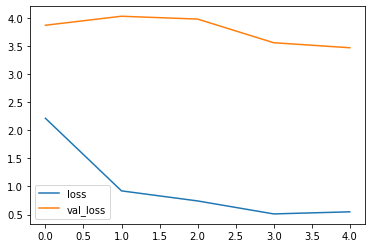

In [20]:
# loss per iteration
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend()

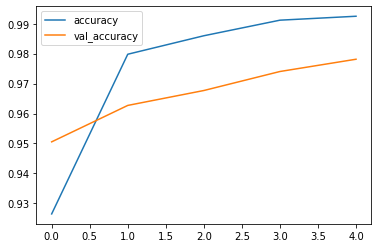

In [21]:
# accuracy per iteration
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

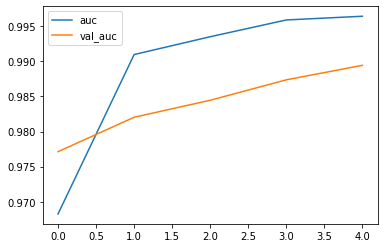

In [23]:
# AUC per iteration
plt.plot(hist.history['auc'], label = 'auc')
plt.plot(hist.history['val_auc'], label = 'val_auc')
plt.legend()

# another solution "using RESNET"